In [1]:
# Import useful things

import numpy as np      
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
from matplotlib import rcParams
import matplotlib.dates as md
import matplotlib.colors as colors
import os
import glob
from scipy import io

#import sys
#sys.path.append('/Users/heather/ICECAPS-ACE/DataParse/')
#from ace_parse import *
#from utils import * 


# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='8'
rcParams['ytick.major.pad']='8'

# Supress warnings for notebook ease of use
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Get capabl data from k9

# Sync all data
# rsync -azvp --progress eehgu@k9.leeds.ac.uk:/home/earrn/foe-data-16/GREENLAND/ICECAPSarchive/capabl/depolprocessing/basicmask/MaskImproved2020*.mat /Volumes/Data/ICECAPSarchive/capabl


In [21]:
dloc = '/Volumes/Data/ICECAPSarchive/capabl/'

# Date of interest

start = dt.datetime(2019,8,9,12,0)
stop = dt.datetime(2019,8,10,12,0)

#start = dt.datetime(2019,7,2,12,0)
#stop = dt.datetime(2019,7,3,12,0)

#start = dt.datetime(2019,7,28,0,0)
#stop = dt.datetime(2019,8,1,0,0)

datetimes=[]
flatten = lambda l: [item for sublist in l for item in sublist]
f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
for ii in range(0,len(f_date_list)): 
    date = f_date_list[ii]
    mask_dict = io.loadmat(dloc + 'MaskImproved%s.mat'%(dt.datetime.strftime(date,'%Y%m%d')),matlab_compatible=True,variable_names=['MergedMask','Altitude','PulseInfo'])
    Altitude = mask_dict['Altitude'][0,0][5].flatten()
    times = mask_dict['PulseInfo'][0,0][-1].flatten()
    datetimes.append([date + dt.timedelta(hours=i) for i in times[~np.isnan(times)]] )
    
    if ii==0:
        Mask = mask_dict['MergedMask'][0,0][0][~np.isnan(times),:]
    else:
        Mask = np.append(Mask,mask_dict['MergedMask'][0,0][0][~np.isnan(times),:],axis=0)



In [22]:
all_dates = flatten(datetimes)

# Subset 0 to 8000m
Altitude = Altitude[0:307]/1000 # km
Mask = np.ma.masked_where(np.isnan(Mask),Mask)
clr = np.ma.masked_where(Mask!=1,Mask)
sv = np.ma.masked_where(Mask!=2,Mask)
liq = np.ma.masked_where(Mask!=3,Mask)
ice = np.ma.masked_where(Mask<4,Mask)

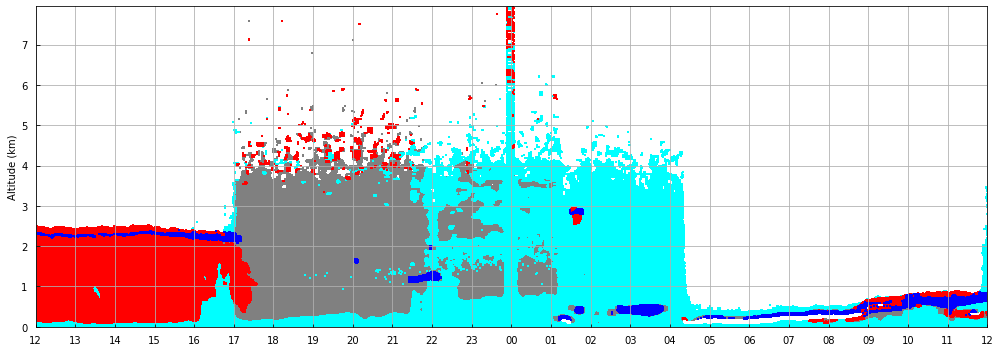

In [23]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(111)
ax1.pcolor(all_dates,Altitude,np.transpose(sv),cmap=colors.ListedColormap(['grey'])) 
ax1.pcolor(all_dates,Altitude,np.transpose(clr),cmap=colors.ListedColormap(['cyan']))  
ax1.pcolor(all_dates,Altitude,np.transpose(ice),cmap=colors.ListedColormap(['r'])) 
ax1.pcolor(all_dates,Altitude,np.transpose(liq),cmap=colors.ListedColormap(['b']))

ax1.set_ylabel('Altitude (km)')
ax1.grid('on')

ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=1))
ax1.set_xlim(start,stop)

fig.tight_layout()    

